In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json


In [2]:
# Cell 1: Import Libraries and Suppress Warnings
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import json

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
base_path = '/kaggle/input/arc-prize-2024/'

def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path) as f:
        return json.load(f)

# Load datasets
datasets = {
    "training_challenges": load_json(base_path + 'arc-agi_training_challenges.json'),
    "training_solutions": load_json(base_path + 'arc-agi_training_solutions.json'),
    "evaluation_challenges": load_json(base_path + 'arc-agi_evaluation_challenges.json'),
    "evaluation_solutions": load_json(base_path + 'arc-agi_evaluation_solutions.json'),
    "test_challenges": load_json(base_path + 'arc-agi_test_challenges.json')
}


In [4]:
cmap = colors.ListedColormap(['black', 'blue', 'red', 'green', 'yellow', 'gray', 'magenta', 'orange', 'cyan', 'brown'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_task(task, task_solution=None):
    """Visualize the input and output pairs of a task."""
    n_train_pairs = len(task['train'])
    n_test_pairs = len(task['test'])
    
    fig, axs = plt.subplots(n_train_pairs + n_test_pairs, 2, figsize=(10, 5 * (n_train_pairs + n_test_pairs)))
    fig.suptitle('Task Visualization', fontsize=16)

    # Plot training pairs
    for i in range(n_train_pairs):
        axs[i, 0].imshow(task['train'][i]['input'], cmap=cmap, norm=norm)
        axs[i, 0].set_title('Train Input')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(task['train'][i]['output'], cmap=cmap, norm=norm)
        axs[i, 1].set_title('Train Output')
        axs[i, 1].axis('off')
    
    # Plot testing pairs
    for i in range(n_test_pairs):
        axs[n_train_pairs + i, 0].imshow(task['test'][i]['input'], cmap=cmap, norm=norm)
        axs[n_train_pairs + i, 0].set_title('Test Input')
        axs[n_train_pairs + i, 0].axis('off')

        if 'output' in task['test'][i]:
            axs[n_train_pairs + i, 1].imshow(task['test'][i]['output'], cmap=cmap, norm=norm)
            axs[n_train_pairs + i, 1].set_title('Test Output (Ground Truth)')
        elif task_solution:
            axs[n_train_pairs + i, 1].imshow(task_solution, cmap=cmap, norm=norm)
            axs[n_train_pairs + i, 1].set_title('Test Output (Predicted)')
        
        axs[n_train_pairs + i, 1].axis('off')

    plt.tight_layout()
    plt.show()


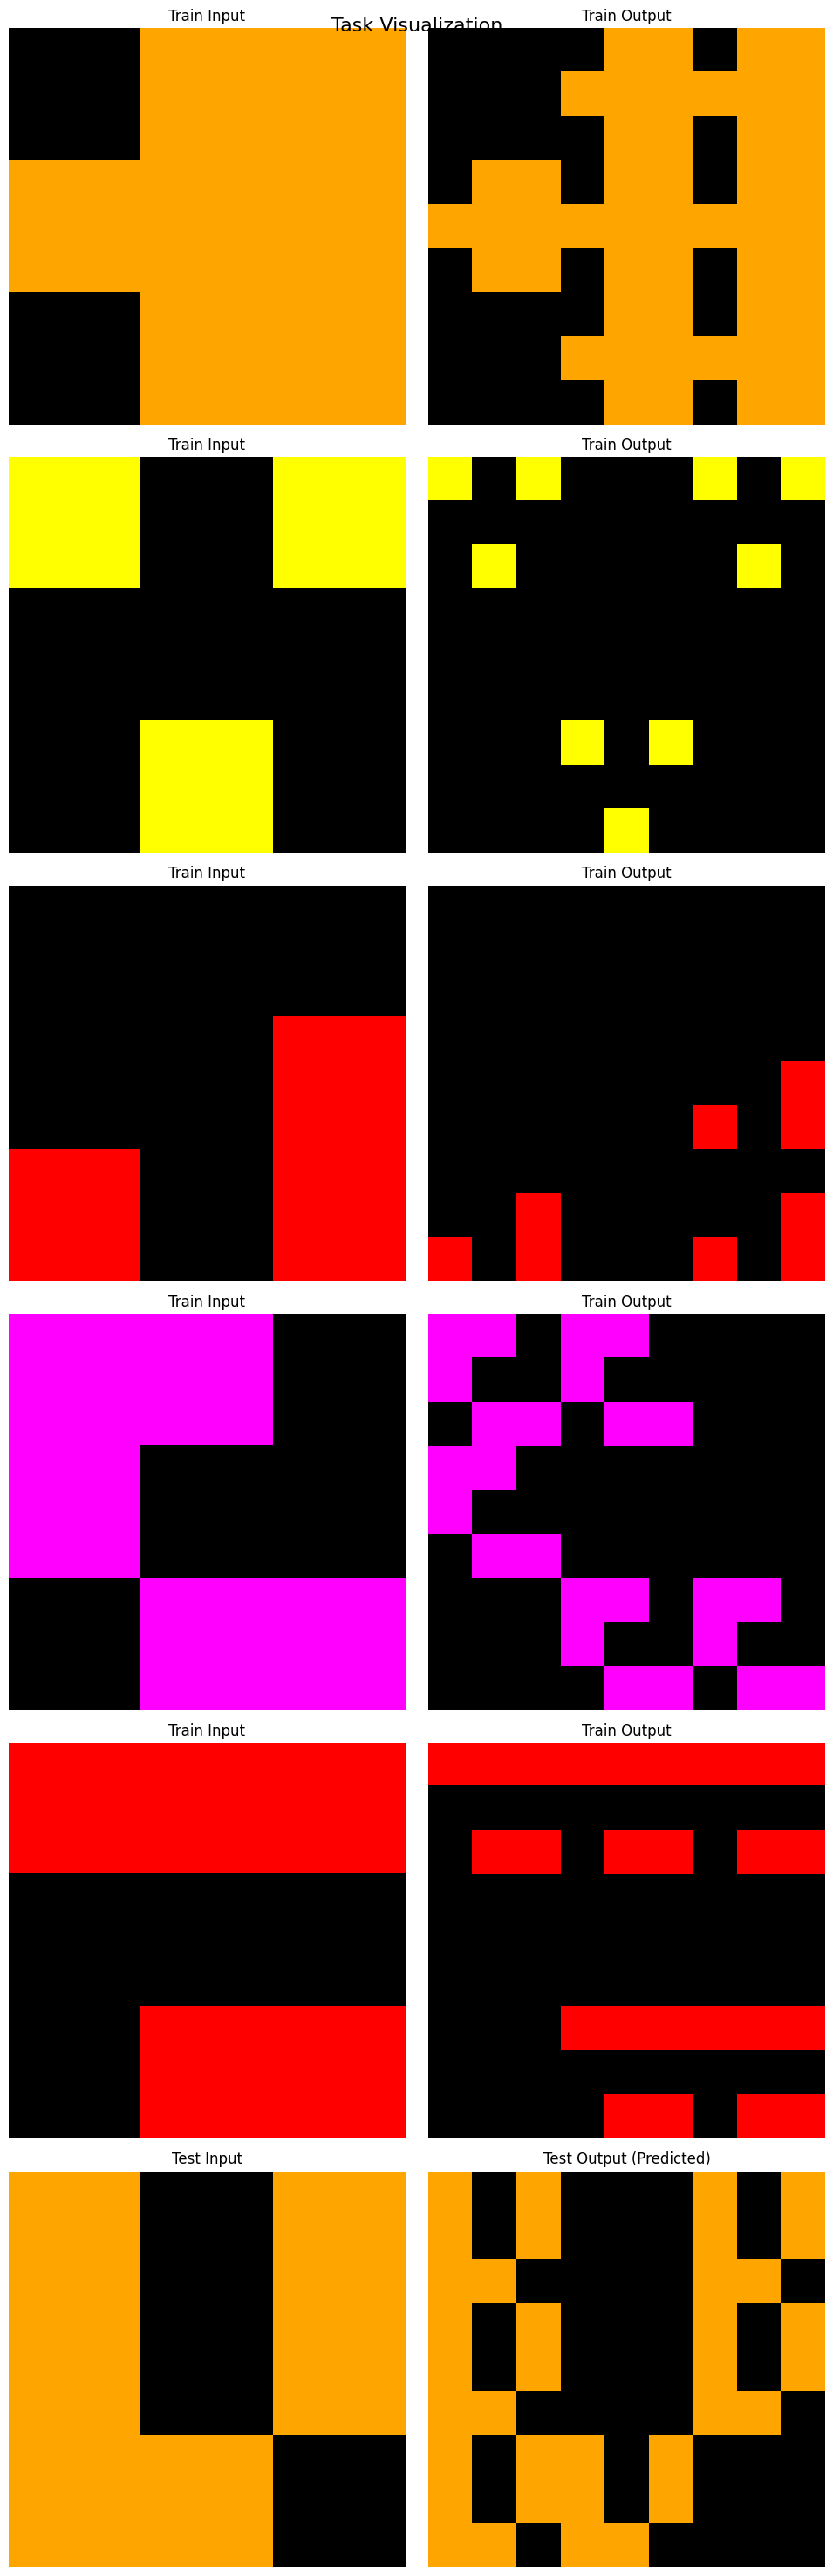

In [5]:
# Cell 4: Plot an Example Task
example_task = datasets['training_challenges']['007bbfb7']
example_solution = datasets['training_solutions']['007bbfb7'][0]
plot_task(example_task, example_solution)

In [6]:
# Cell 5: Exploratory Data Analysis - Task Dimensions
def get_dimensions(task):
    """Retrieve dimensions of training and testing tasks."""
    train_dims = [tuple(np.array(pair['input']).shape) for pair in task['train']]
    test_dims = [tuple(np.array(pair['input']).shape) for pair in task['test']]
    return train_dims, test_dims

train_dims, test_dims = get_dimensions(example_task)
print('Training dimensions:', train_dims)
print('Testing dimensions:', test_dims)

Training dimensions: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Testing dimensions: [(3, 3)]


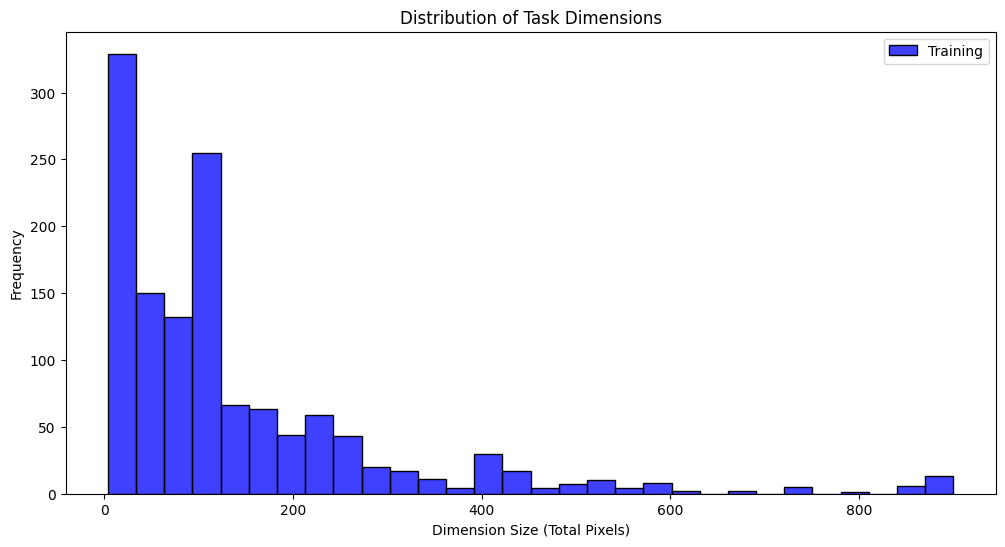

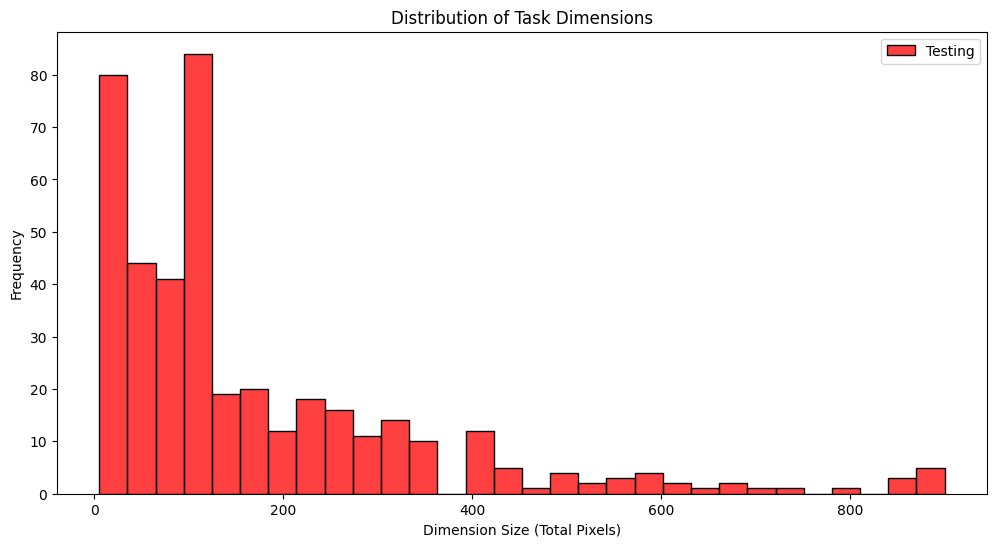

In [7]:
# Cell 6: Distribution of Task Dimensions for the Entire Dataset
def plot_dimension_distribution(dimensions, label, color):
    """Plot the distribution of task dimensions."""
    dims_series = pd.Series(dimensions)
    plt.figure(figsize=(12, 6))
    sns.histplot(dims_series.apply(lambda x: x[0] * x[1]), color=color, label=label, bins=30)
    plt.xlabel('Dimension Size (Total Pixels)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of Task Dimensions')
    plt.show()

train_dims_all = []
test_dims_all = []

for task in datasets['training_challenges'].values():
    td, tsd = get_dimensions(task)
    train_dims_all.extend(td)
    test_dims_all.extend(tsd)

plot_dimension_distribution(train_dims_all, 'Training', 'blue')
plot_dimension_distribution(test_dims_all, 'Testing', 'red')

In [8]:
# Cell 7: Distribution of Colors Used
def count_colors(grid):
    """Count the frequency of each color in a grid."""
    flat_grid = np.array(grid).flatten()
    return pd.Series(flat_grid).value_counts().sort_index()

task_colors = count_colors(example_task['train'][0]['input'])
print(task_colors)

0    2
7    7
Name: count, dtype: int64


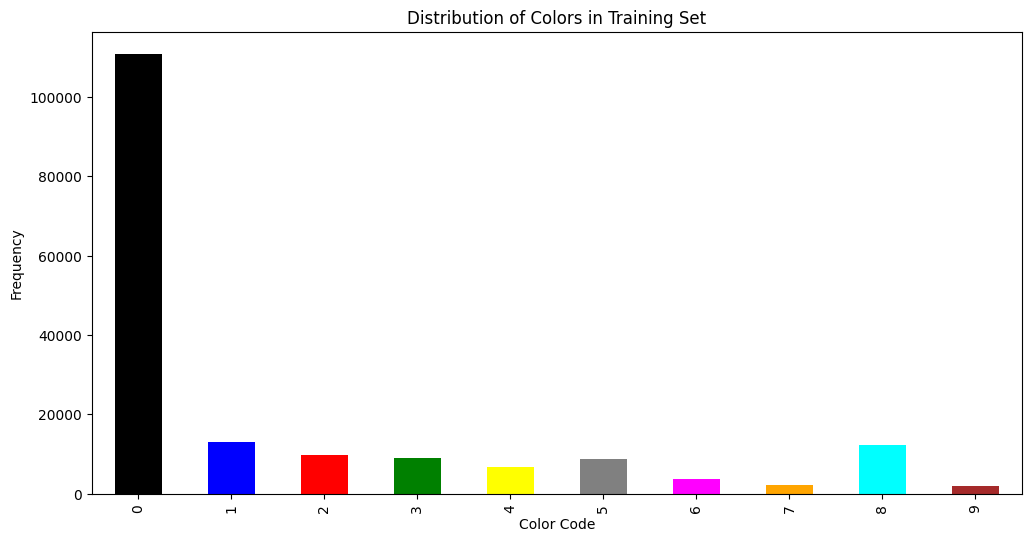

In [9]:
# Cell 8: Aggregate Color Usage for All Tasks
all_colors = pd.Series(dtype=int)

for task in datasets['training_challenges'].values():
    for pair in task['train']:
        all_colors = all_colors.add(count_colors(pair['input']), fill_value=0)

all_colors.replace([np.inf, -np.inf], np.nan, inplace=True)
all_colors.dropna(inplace=True)

plt.figure(figsize=(12, 6))
all_colors.sort_index().plot(kind='bar', color=cmap.colors)
plt.xlabel('Color Code')
plt.ylabel('Frequency')
plt.title('Distribution of Colors in Training Set')
plt.show()

In [10]:
# Cell 9: Baseline Model - Simple Transformations
def simple_transform(grid, transformation):
    """Apply a simple transformation to a grid."""
    if transformation == 'rotate_90':
        return np.rot90(grid).tolist()
    elif transformation == 'mirror':
        return np.fliplr(grid).tolist()
    return grid

def evaluate_baseline(task, transformation):
    """Evaluate the baseline model on a single task using a specified transformation."""
    for i, pair in enumerate(task['test']):
        predicted = simple_transform(pair['input'], transformation)
        print(f'Test Pair {i} - Predicted Output:')
        print(predicted)

In [11]:
# Cell 10: Evaluate Baseline Model
evaluate_baseline(example_task, 'rotate_90')


Test Pair 0 - Predicted Output:
[[7, 7, 0], [0, 0, 7], [7, 7, 7]]


In [12]:
import json

def create_submission(predictions, output_path):
    """
    Create a submission JSON file with exactly 2 predictions (attempt_1 and attempt_2) per task.
    Each task should have a list of exactly 2 prediction dictionaries.
    """
    if not isinstance(predictions, dict):
        raise ValueError("Predictions should be a dictionary")
    
    # Ensure each task has exactly 2 predictions
    for task_id, preds in predictions.items():
        if len(preds) != 2:
            raise ValueError(f"Task {task_id} must have exactly 2 predictions")

    with open(output_path, 'w') as file:
        json.dump(predictions, file, indent=4, ensure_ascii=False)

    print(f"Submission file created and saved to '{output_path}'.")

# Define example predictions
example_predictions = {
    "007bbfb7": [
        {"attempt_1": [[7, 7, 0], [0, 0, 7], [7, 7, 7]]},
        {"attempt_2": [[7, 7, 0], [0, 0, 7], [7, 7, 7]]}
    ],
    "12997ef3": [
        {"attempt_1": [[0, 1, 0], [1, 0, 1], [0, 1, 0]]},
        {"attempt_2": [[0, 1, 0], [1, 0, 1], [0, 1, 0]]}
    ]
}

# Create and save the submission file
create_submission(example_predictions, 'submission.json')


Submission file created and saved to 'submission.json'.


In [13]:
with open('submission.json') as f:
    submission = json.load(f)
print(json.dumps(submission, indent=4))


{
    "007bbfb7": [
        {
            "attempt_1": [
                [
                    7,
                    7,
                    0
                ],
                [
                    0,
                    0,
                    7
                ],
                [
                    7,
                    7,
                    7
                ]
            ]
        },
        {
            "attempt_2": [
                [
                    7,
                    7,
                    0
                ],
                [
                    0,
                    0,
                    7
                ],
                [
                    7,
                    7,
                    7
                ]
            ]
        }
    ],
    "12997ef3": [
        {
            "attempt_1": [
                [
                    0,
                    1,
                    0
                ],
                [
                    1,
                    0

In [14]:
create_submission(example_predictions, 'submission.json')

Submission file created and saved to 'submission.json'.
